In [1]:
%%configure -f
{ "conf":{
"spark.pyspark.virtualenv.enabled": "false"
}}

In [2]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.window import Window
from pyspark.sql import functions as F

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1587772236795_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%local
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
sum(confirmed) as numConfirmed, sum(deaths) as numDeaths,sum(recovered) as numRecovered,admin2,province_state, 
concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or 
province_state = 'California' or province_state = 'Washington' or province_state = 'District of Columbia' ) 
group by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|               date|numConfirmed|numDeaths|numRecovered|              admin2|      province_state|              county|
+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|2020-03-22 00:00:00|        1040|       75|           0|                King|          Washington|   King - Washington|
|2020-03-22 00:00:00|         480|       10|           0|           Snohomish|          Washington|Snohomish - Washi...|
|2020-03-22 00:00:00|         407|        5|           0|         Los Angeles|          California|Los Angeles - Cal...|
|2020-03-22 00:00:00|         263|        8|           0|         Santa Clara|          California|Santa Clara - Cal...|
|2020-03-22 00:00:00|         204|        2|           0|District of Columbia|District of Columbia|District of Colum...|
|2020-03-22 00:00:00|         16

In [5]:
%%spark -o df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

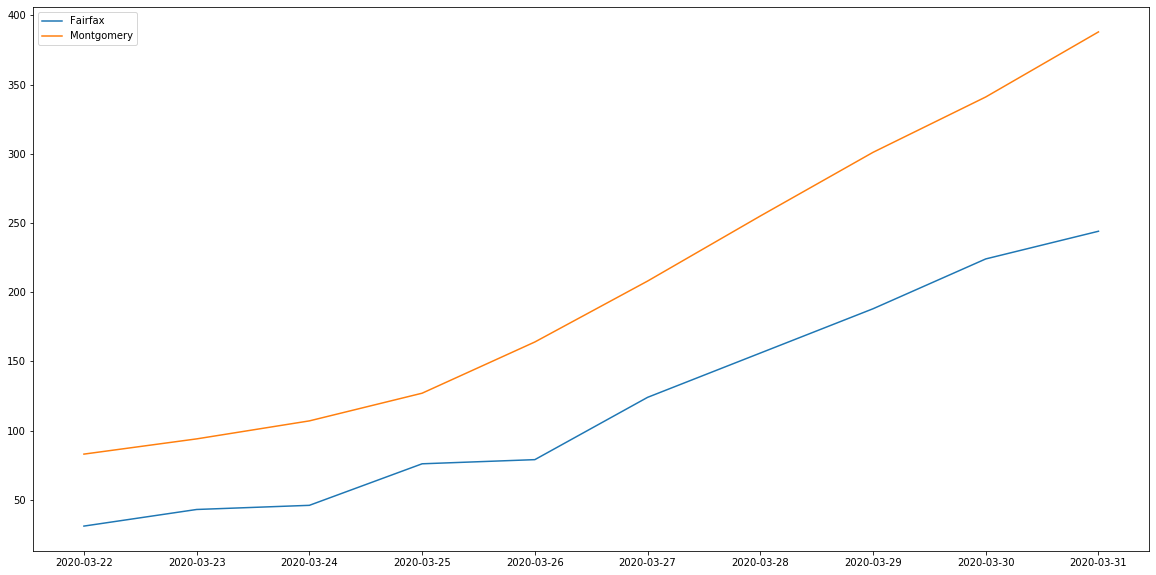

In [6]:
%local
plt.figure(figsize=(20,10))
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Fairfax') & (df['province_state'] == 'Virginia')],label="Fairfax")
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Montgomery') & (df['province_state'] == 'Maryland')],label="Montgomery")
plt.legend()
plt.show()


In [7]:
df_topcounties = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' or 
( province_state = 'California' and admin2 = 'Los Angeles' ) or 
( province_state = 'Washington' and admin2 = 'King' ) ) 
group by admin2,province_state
order by max(confirmed) desc
limit 20""")
df_topcounties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|Los Angeles - Cal...|
|   King - Washington|
|Prince George's -...|
|District of Colum...|
|Montgomery - Mary...|
|  Fairfax - Virginia|
|Baltimore - Maryland|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|Prince William - ...|
|  Henrico - Virginia|
|Frederick - Maryland|
|Arlington - Virginia|
|   Howard - Maryland|
|Alexandria - Virg...|
|  Loudoun - Virginia|
|  Charles - Maryland|
|Chesterfield - Vi...|
|  Carroll - Maryland|
|Harrisonburg - Vi...|
+--------------------+

In [8]:
%spark -o df_topcounties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

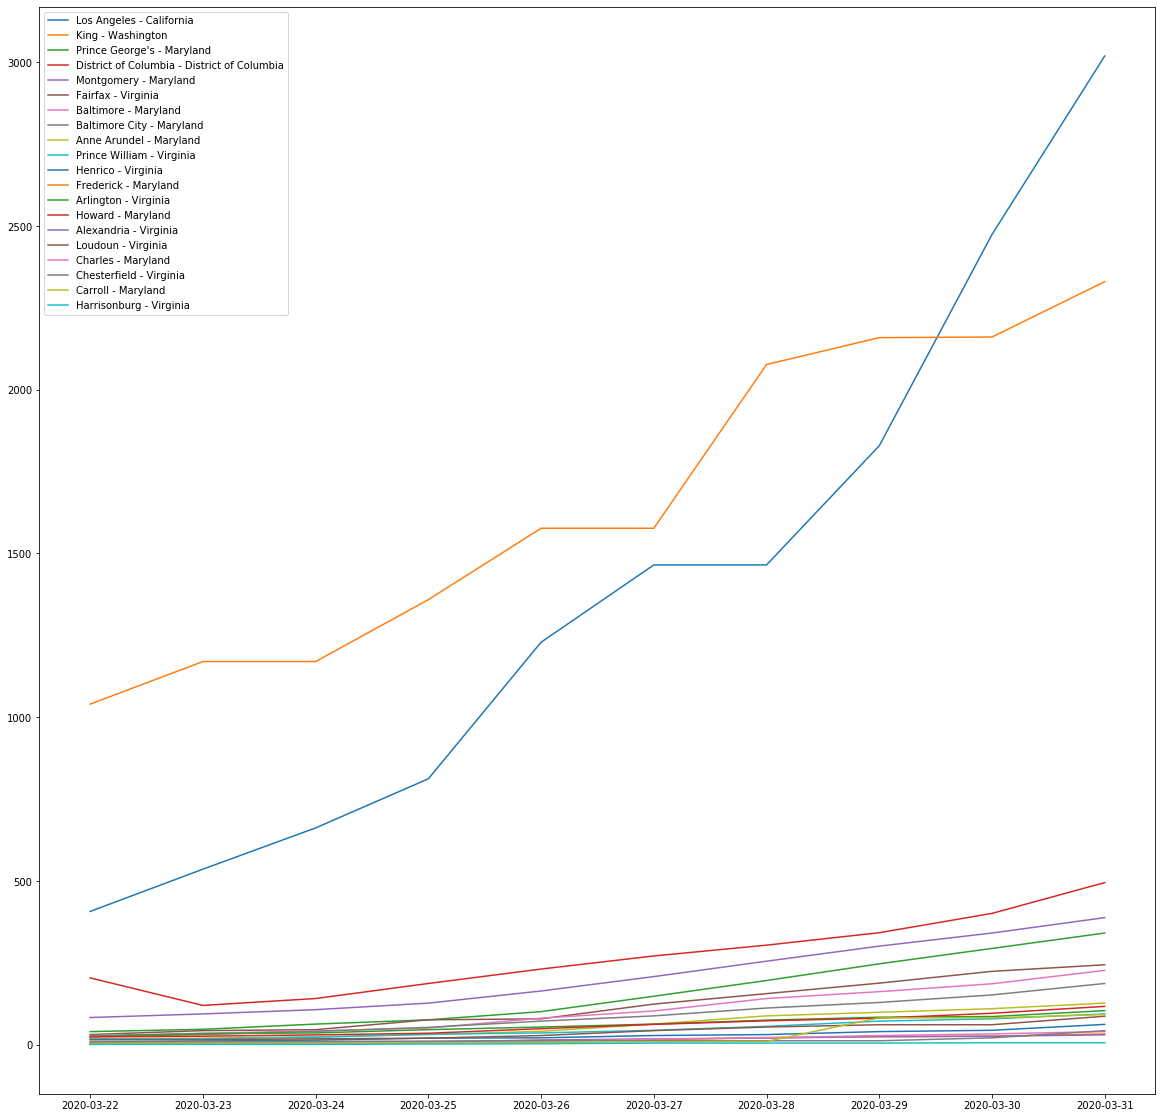

In [9]:
%local
plt.figure(figsize=(20,20))
for index in df_topcounties.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties['county'][index]],label=df_topcounties['county'][index])
  plt.text
plt.legend()
plt.show()

In [10]:
df_dmv = spark.sql("""select max(confirmed) as numConfirmed, admin2, province_state 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by max(confirmed) desc""")
df_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+--------------------+
|numConfirmed|              admin2|      province_state|
+------------+--------------------+--------------------+
|        4141|     Prince George's|            Maryland|
|        3361|District of Columbia|District of Columbia|
|        3060|          Montgomery|            Maryland|
|        2362|             Fairfax|            Virginia|
|        2132|           Baltimore|            Maryland|
|        1672|      Baltimore City|            Maryland|
|        1294|        Anne Arundel|            Maryland|
|        1027|      Prince William|            Virginia|
|         718|             Henrico|            Virginia|
|         690|           Frederick|            Maryland|
|         686|           Arlington|            Virginia|
|         618|              Howard|            Maryland|
|         512|          Alexandria|            Virginia|
|         498|             Loudoun|            Virginia|
|         442|             Char

In [11]:
%spark -o df_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_topcounties_dmv = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by max(confirmed) desc
limit 10""")
df_topcounties_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|Prince George's -...|
|District of Colum...|
|Montgomery - Mary...|
|  Fairfax - Virginia|
|Baltimore - Maryland|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|Prince William - ...|
|  Henrico - Virginia|
|Frederick - Maryland|
+--------------------+

In [13]:
%spark -o df_topcounties_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

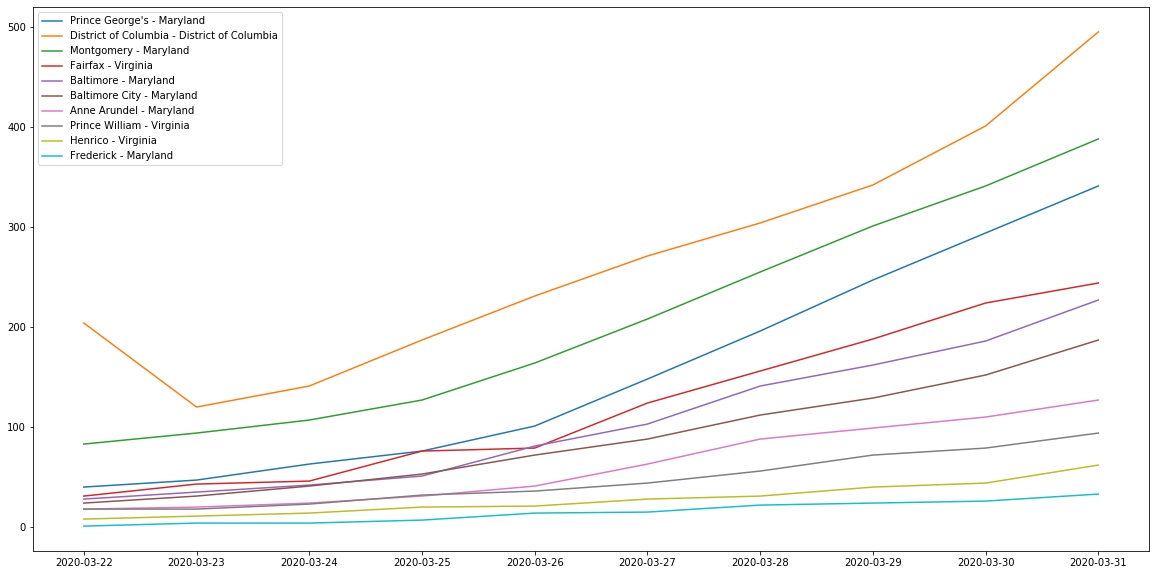

In [14]:
%local
plt.figure(figsize=(20,10))
for index in df_topcounties_dmv.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties_dmv['county'][index]],label=df_topcounties_dmv['county'][index])
  plt.text
plt.legend()
plt.show()

In [15]:
df_fairfax = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed, sum(deaths) as numDeaths
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' ) and ( admin2 = 'Fairfax' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_fairfax.show(df_fairfax.count(), False)

my_window = Window.partitionBy().orderBy("date")

df_fairfax = df_fairfax.withColumn("dayBefore", F.lag(df_fairfax.numConfirmed).over(my_window))
df_fairfax = df_fairfax.withColumn("change", F.when(F.isnull(df_fairfax.numConfirmed - df_fairfax.dayBefore), 0).otherwise(df_fairfax.numConfirmed - df_fairfax.dayBefore))

df_fairfax = df_fairfax.withColumn("dayBeforeDeaths", F.lag(df_fairfax.numDeaths).over(my_window))
df_fairfax = df_fairfax.withColumn("changeDeaths", F.when(F.isnull(df_fairfax.numDeaths - df_fairfax.dayBeforeDeaths), 0).otherwise(df_fairfax.numDeaths - df_fairfax.dayBeforeDeaths))


df_fairfax.show(df_fairfax.count(), False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+------------+---------+
|date               |county |numConfirmed|numDeaths|
+-------------------+-------+------------+---------+
|2020-03-22 00:00:00|Fairfax|31          |1        |
|2020-03-23 00:00:00|Fairfax|43          |1        |
|2020-03-24 00:00:00|Fairfax|46          |1        |
|2020-03-25 00:00:00|Fairfax|76          |1        |
|2020-03-26 00:00:00|Fairfax|79          |1        |
|2020-03-27 00:00:00|Fairfax|124         |1        |
|2020-03-28 00:00:00|Fairfax|156         |2        |
|2020-03-29 00:00:00|Fairfax|188         |2        |
|2020-03-30 00:00:00|Fairfax|224         |2        |
|2020-03-31 00:00:00|Fairfax|244         |2        |
|2020-04-01 00:00:00|Fairfax|288         |2        |
|2020-04-02 00:00:00|Fairfax|328         |2        |
|2020-04-03 00:00:00|Fairfax|372         |2        |
|2020-04-04 00:00:00|Fairfax|387         |2        |
|2020-04-05 00:00:00|Fairfax|426         |2        |
|2020-04-06 00:00:00|Fairfax|488         |2   

In [16]:
%spark -o df_fairfax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df_arlington = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed, sum(deaths) as numDeaths 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' ) and ( admin2 = 'Arlington' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_arlington.show()

my_window = Window.partitionBy().orderBy("date")

df_arlington = df_arlington.withColumn("dayBefore", F.lag(df_arlington.numConfirmed).over(my_window))
df_arlington = df_arlington.withColumn("change", F.when(F.isnull(df_arlington.numConfirmed - df_arlington.dayBefore), 0).otherwise(df_arlington.numConfirmed - df_arlington.dayBefore))

df_arlington = df_arlington.withColumn("dayBeforeDeaths", F.lag(df_arlington.numDeaths).over(my_window))
df_arlington = df_arlington.withColumn("changeDeaths", F.when(F.isnull(df_arlington.numDeaths - df_arlington.dayBeforeDeaths), 0).otherwise(df_arlington.numDeaths - df_arlington.dayBeforeDeaths))


df_arlington.show(df_arlington.count(), False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------+------------+---------+
|               date|   county|numConfirmed|numDeaths|
+-------------------+---------+------------+---------+
|2020-03-22 00:00:00|Arlington|          26|        0|
|2020-03-23 00:00:00|Arlington|          34|        0|
|2020-03-24 00:00:00|Arlington|          36|        0|
|2020-03-25 00:00:00|Arlington|          46|        0|
|2020-03-26 00:00:00|Arlington|          54|        0|
|2020-03-27 00:00:00|Arlington|          63|        0|
|2020-03-28 00:00:00|Arlington|          75|        0|
|2020-03-29 00:00:00|Arlington|          84|        2|
|2020-03-30 00:00:00|Arlington|          86|        2|
|2020-03-31 00:00:00|Arlington|         104|        2|
|2020-04-01 00:00:00|Arlington|         119|        2|
|2020-04-02 00:00:00|Arlington|         128|        2|
|2020-04-03 00:00:00|Arlington|         135|        2|
|2020-04-04 00:00:00|Arlington|         150|        2|
|2020-04-05 00:00:00|Arlington|         181|        2|
|2020-04-0

In [18]:
%spark -o df_arlington

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_montgomery = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed, sum(deaths) as numDeaths  
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Maryland' ) and ( admin2 = 'Montgomery' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_montgomery.show()

my_window = Window.partitionBy().orderBy("date")

df_montgomery = df_montgomery.withColumn("dayBefore", F.lag(df_montgomery.numConfirmed).over(my_window))
df_montgomery = df_montgomery.withColumn("change", F.when(F.isnull(df_montgomery.numConfirmed - df_montgomery.dayBefore), 0).otherwise(df_montgomery.numConfirmed - df_montgomery.dayBefore))

df_montgomery = df_montgomery.withColumn("dayBeforeDeaths", F.lag(df_montgomery.numDeaths).over(my_window))
df_montgomery = df_montgomery.withColumn("changeDeaths", F.when(F.isnull(df_montgomery.numDeaths - df_montgomery.dayBeforeDeaths), 0).otherwise(df_montgomery.numDeaths - df_montgomery.dayBeforeDeaths))


df_montgomery.show(df_montgomery.count(), False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+---------+
|               date|    county|numConfirmed|numDeaths|
+-------------------+----------+------------+---------+
|2020-03-22 00:00:00|Montgomery|          83|        1|
|2020-03-23 00:00:00|Montgomery|          94|        1|
|2020-03-24 00:00:00|Montgomery|         107|        1|
|2020-03-25 00:00:00|Montgomery|         127|        1|
|2020-03-26 00:00:00|Montgomery|         164|        1|
|2020-03-27 00:00:00|Montgomery|         208|        1|
|2020-03-28 00:00:00|Montgomery|         255|        1|
|2020-03-29 00:00:00|Montgomery|         301|        1|
|2020-03-30 00:00:00|Montgomery|         341|        1|
|2020-03-31 00:00:00|Montgomery|         388|        1|
|2020-04-01 00:00:00|Montgomery|         447|        1|
|2020-04-02 00:00:00|Montgomery|         498|        6|
|2020-04-03 00:00:00|Montgomery|         566|        9|
|2020-04-04 00:00:00|Montgomery|         640|        9|
|2020-04-05 00:00:00|Montgomery|         693|   

In [20]:
%spark -o df_montgomery

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
df_dc = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed, sum(deaths) as numDeaths 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'District of Columbia' )
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_dc.show()

my_window = Window.partitionBy().orderBy("date")

df_dc = df_dc.withColumn("dayBefore", F.lag(df_dc.numConfirmed).over(my_window))
df_dc = df_dc.withColumn("change", F.when(F.isnull(df_dc.numConfirmed - df_dc.dayBefore), 0).otherwise(df_dc.numConfirmed - df_dc.dayBefore))

df_dc = df_dc.withColumn("dayBeforeDeaths", F.lag(df_dc.numDeaths).over(my_window))
df_dc = df_dc.withColumn("changeDeaths", F.when(F.isnull(df_dc.numDeaths - df_dc.dayBeforeDeaths), 0).otherwise(df_dc.numDeaths - df_dc.dayBeforeDeaths))


df_dc.show(df_dc.count(), False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+------------+---------+
|               date|              county|numConfirmed|numDeaths|
+-------------------+--------------------+------------+---------+
|2020-03-22 00:00:00|District of Columbia|         204|        2|
|2020-03-23 00:00:00|District of Columbia|         120|        2|
|2020-03-24 00:00:00|District of Columbia|         141|        2|
|2020-03-25 00:00:00|District of Columbia|         187|        2|
|2020-03-26 00:00:00|District of Columbia|         231|        3|
|2020-03-27 00:00:00|District of Columbia|         271|        3|
|2020-03-28 00:00:00|District of Columbia|         304|        4|
|2020-03-29 00:00:00|District of Columbia|         342|        5|
|2020-03-30 00:00:00|District of Columbia|         401|        9|
|2020-03-31 00:00:00|District of Columbia|         495|        9|
|2020-04-01 00:00:00|District of Columbia|         586|        9|
|2020-04-02 00:00:00|District of Columbia|         653|       12|
|2020-04-0

In [22]:
%spark -o df_dc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

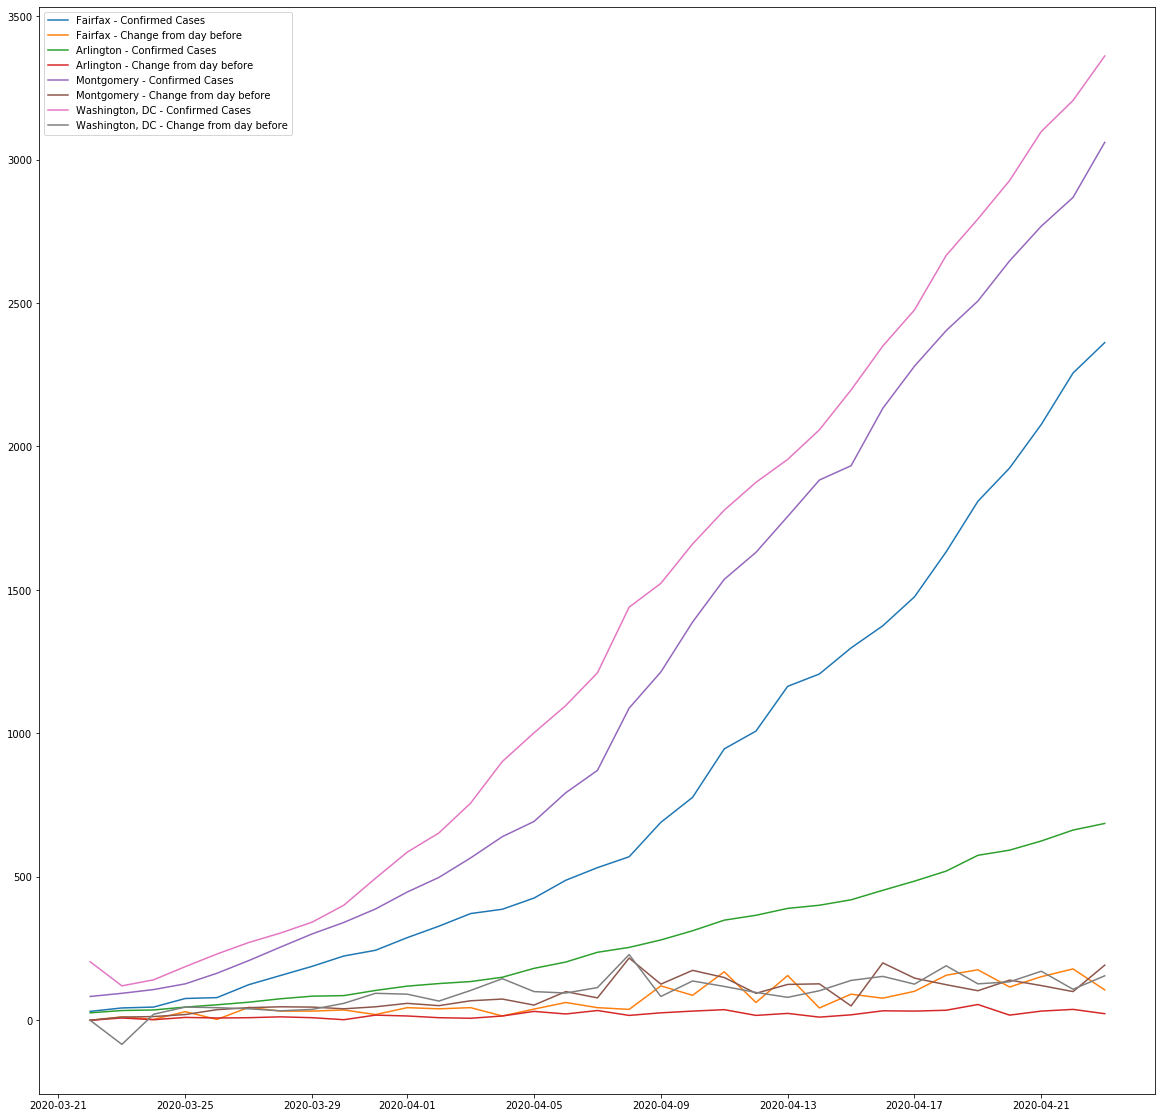

In [23]:
%local
plt.figure(figsize=(20,20))
plt.plot('date', 'numConfirmed', data=df_fairfax, label="Fairfax - Confirmed Cases")
plt.plot('date', 'change', data=df_fairfax, label="Fairfax - Change from day before")
plt.plot('date', 'numConfirmed', data=df_arlington, label="Arlington - Confirmed Cases")
plt.plot('date', 'change', data=df_arlington, label="Arlington - Change from day before")
plt.plot('date', 'numConfirmed', data=df_montgomery, label="Montgomery - Confirmed Cases")
plt.plot('date', 'change', data=df_montgomery, label="Montgomery - Change from day before")
plt.plot('date', 'numConfirmed', data=df_dc, label="Washington, DC - Confirmed Cases")
plt.plot('date', 'change', data=df_dc, label="Washington, DC - Change from day before")
plt.text
plt.legend()
plt.show()

In [24]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
df_states_dmv = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date,
sum(confirmed) as numConfirmed, sum(deaths) as numDeaths, province_state  
from covid19.jhu_daily_new
where year = '2020' and int(month) > 2 and
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' )
group by year, month, day, province_state
order by year, month, day, sum(confirmed) desc""")
df_states_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+--------------------+
|               date|numConfirmed|numDeaths|      province_state|
+-------------------+------------+---------+--------------------+
|2020-03-22 00:00:00|         244|        3|            Maryland|
|2020-03-22 00:00:00|         220|        6|            Virginia|
|2020-03-22 00:00:00|         204|        2|District of Columbia|
|2020-03-23 00:00:00|         290|        3|            Maryland|
|2020-03-23 00:00:00|         254|        6|            Virginia|
|2020-03-23 00:00:00|         120|        2|District of Columbia|
|2020-03-24 00:00:00|         349|        4|            Maryland|
|2020-03-24 00:00:00|         293|        9|            Virginia|
|2020-03-24 00:00:00|         141|        2|District of Columbia|
|2020-03-25 00:00:00|         425|        4|            Maryland|
|2020-03-25 00:00:00|         396|        9|            Virginia|
|2020-03-25 00:00:00|         187|        2|District of Columbia|
|2020-03-2

In [25]:
%spark -o df_states_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

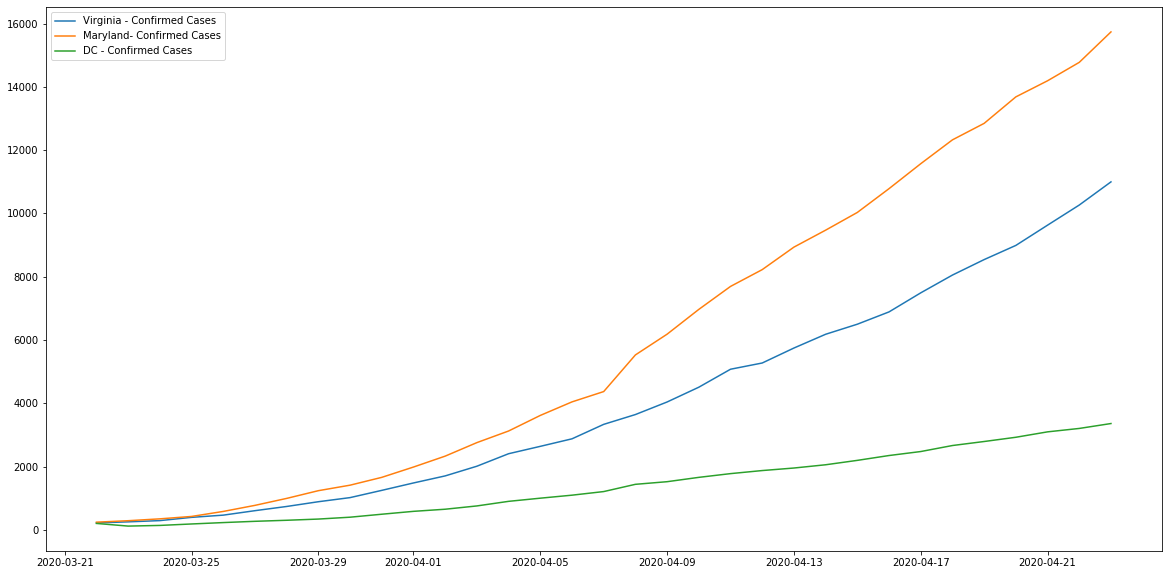

In [26]:
%local
plt.figure(figsize=(20,10))
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'Virginia'], label="Virginia - Confirmed Cases")
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'Maryland'], label="Maryland- Confirmed Cases")
plt.plot('date', 'numConfirmed', data=df_states_dmv.loc[df_states_dmv['province_state'] == 'District of Columbia'], label="DC - Confirmed Cases")
plt.text
plt.legend()
plt.show()

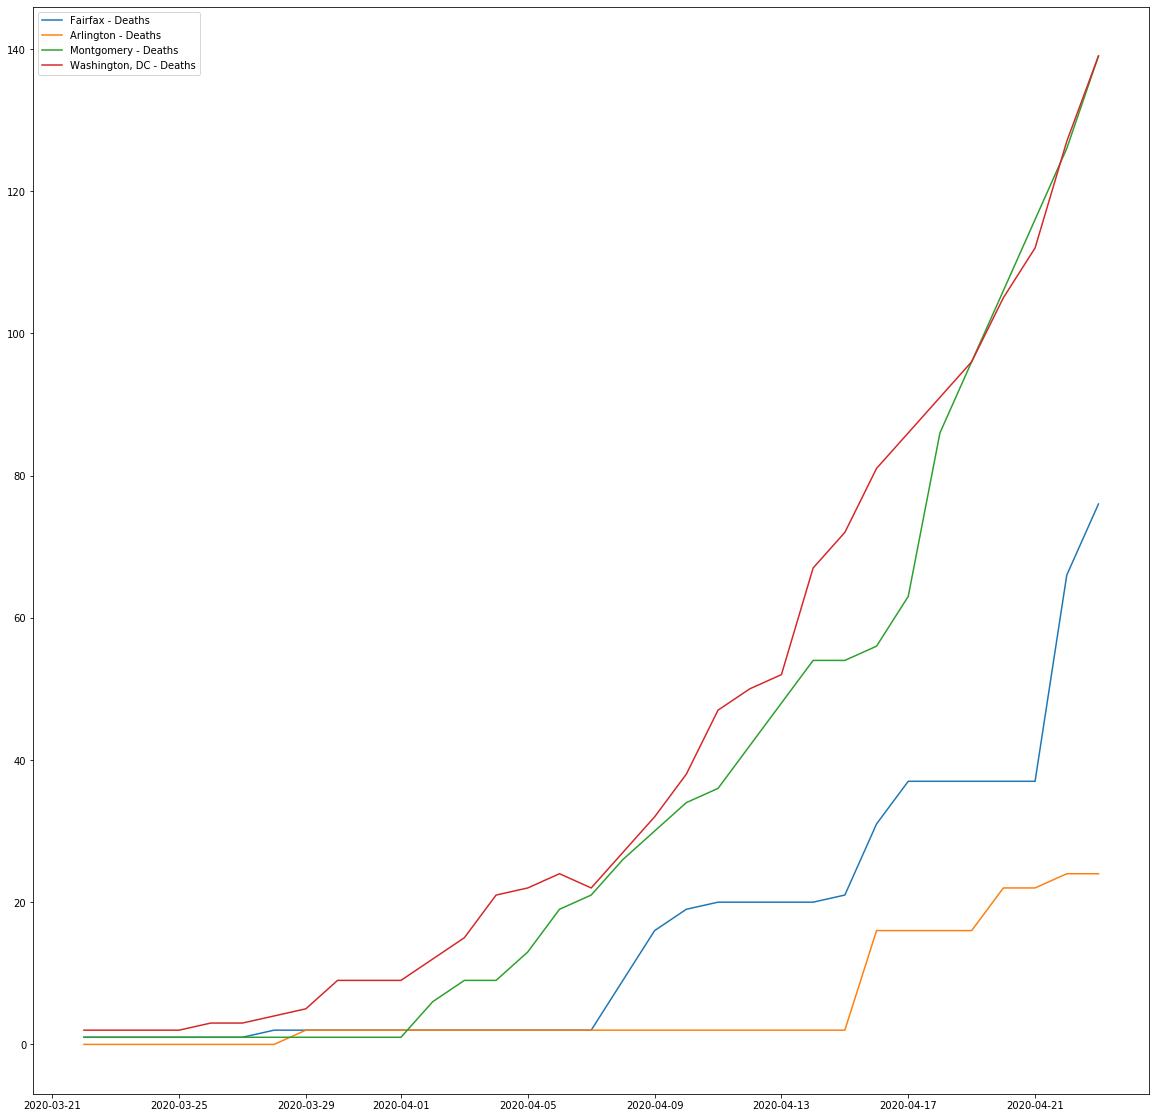

In [27]:
%local
plt.figure(figsize=(20,20))
plt.plot('date', 'numDeaths', data=df_fairfax, label="Fairfax - Deaths")
plt.plot('date', 'numDeaths', data=df_arlington, label="Arlington - Deaths")
plt.plot('date', 'numDeaths', data=df_montgomery, label="Montgomery - Deaths")
plt.plot('date', 'numDeaths', data=df_dc, label="Washington, DC - Deaths")
plt.text
plt.legend()
plt.show()

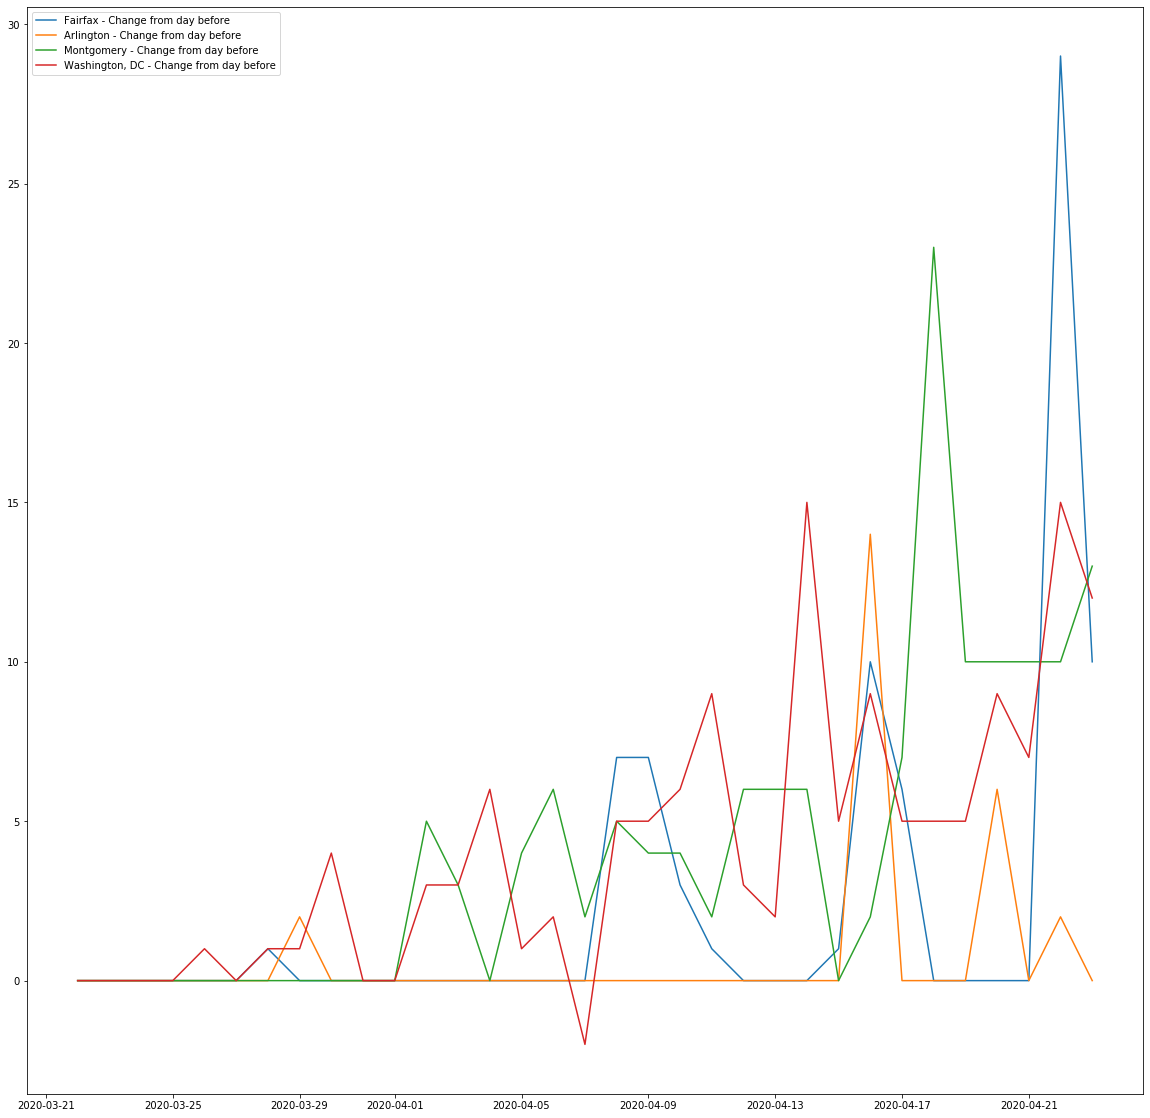

In [28]:
%local
plt.figure(figsize=(20,20))
plt.plot('date', 'changeDeaths', data=df_fairfax, label="Fairfax - Change from day before")
plt.plot('date', 'changeDeaths', data=df_arlington, label="Arlington - Change from day before")
plt.plot('date', 'changeDeaths', data=df_montgomery, label="Montgomery - Change from day before")
plt.plot('date', 'changeDeaths', data=df_dc, label="Washington, DC - Change from day before")
plt.text
plt.legend()
plt.show()

In [29]:
df_dmv = df_fairfax.union(df_arlington).union(df_montgomery).union(df_dc)
movAvgSpec = Window.partitionBy("county").orderBy("date").rowsBetween(-3,0)

df_dmv_movAvg = df_dmv.withColumn( "movingAverage", F.avg("change").over(movAvgSpec) )
df_dmv_movAvg.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+---------+---------+------+---------------+------------+-------------+
|               date|    county|numConfirmed|numDeaths|dayBefore|change|dayBeforeDeaths|changeDeaths|movingAverage|
+-------------------+----------+------------+---------+---------+------+---------------+------------+-------------+
|2020-03-22 00:00:00|Montgomery|          83|        1|     null|     0|           null|           0|          0.0|
|2020-03-23 00:00:00|Montgomery|          94|        1|       83|    11|              1|           0|          5.5|
|2020-03-24 00:00:00|Montgomery|         107|        1|       94|    13|              1|           0|          8.0|
|2020-03-25 00:00:00|Montgomery|         127|        1|      107|    20|              1|           0|         11.0|
|2020-03-26 00:00:00|Montgomery|         164|        1|      127|    37|              1|           0|        20.25|
|2020-03-27 00:00:00|Montgomery|         208|        1|      164|    44|

In [30]:
%spark -o df_dmv_movAvg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
df_dmv_counties = spark.sql("""select admin2 as county  
from covid19.jhu_daily_new 
where ( province_state = 'Virginia' and admin2 = 'Fairfax' ) or 
( province_state = 'Virginia' and admin2 = 'Arlington' ) or 
( province_state = 'Maryland' and admin2 = 'Montgomery' ) or 
province_state = 'District of Columbia'
group by county
""")
df_dmv_counties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|          Montgomery|
|District of Columbia|
|           Arlington|
|             Fairfax|
+--------------------+

In [32]:
%spark -o df_dmv_counties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

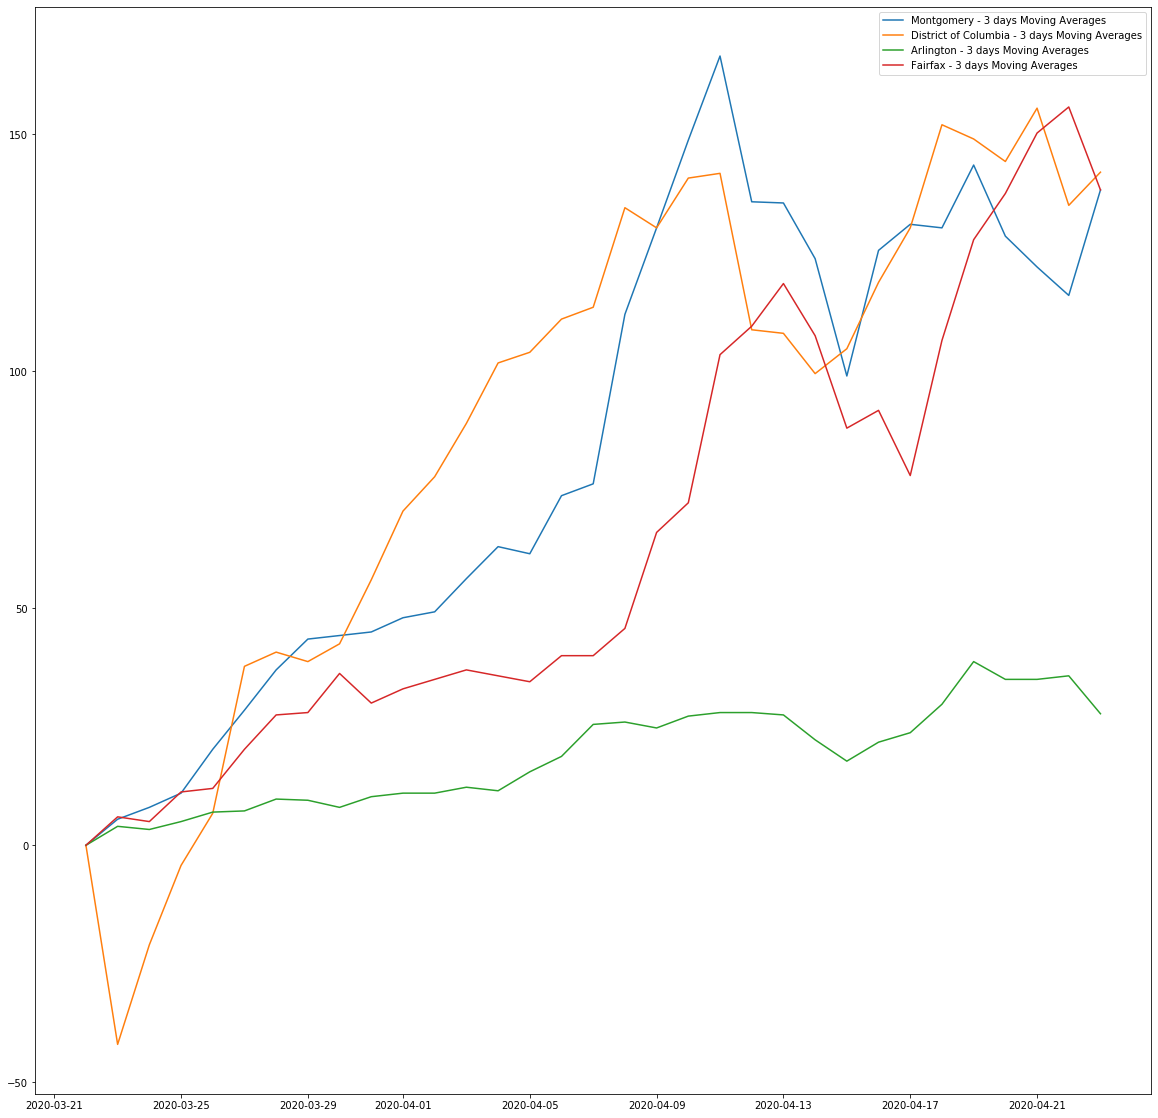

In [33]:
%local
plt.figure(figsize=(20,20))
for index in df_dmv_counties.index:
  plt.plot('date', 'movingAverage', data=df_dmv_movAvg.loc[df_dmv_movAvg['county']==df_dmv_counties['county'][index]],label=df_dmv_counties['county'][index] + ' - 3 days Moving Averages')
  plt.text
plt.legend()
plt.show()

In [34]:
rateChangeSpec = Window.partitionBy("county").orderBy("date").rowsBetween(-1,0)

df_dmv_rateChange = df_dmv.withColumn( "RateOfChange", F.avg("change").over(rateChangeSpec) )
df_dmv_rateChange.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+------------+---------+---------+------+---------------+------------+------------+
|               date|    county|numConfirmed|numDeaths|dayBefore|change|dayBeforeDeaths|changeDeaths|RateOfChange|
+-------------------+----------+------------+---------+---------+------+---------------+------------+------------+
|2020-03-22 00:00:00|Montgomery|          83|        1|     null|     0|           null|           0|         0.0|
|2020-03-23 00:00:00|Montgomery|          94|        1|       83|    11|              1|           0|         5.5|
|2020-03-24 00:00:00|Montgomery|         107|        1|       94|    13|              1|           0|        12.0|
|2020-03-25 00:00:00|Montgomery|         127|        1|      107|    20|              1|           0|        16.5|
|2020-03-26 00:00:00|Montgomery|         164|        1|      127|    37|              1|           0|        28.5|
|2020-03-27 00:00:00|Montgomery|         208|        1|      164|    44|        

In [35]:
%spark -o df_dmv_rateChange

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

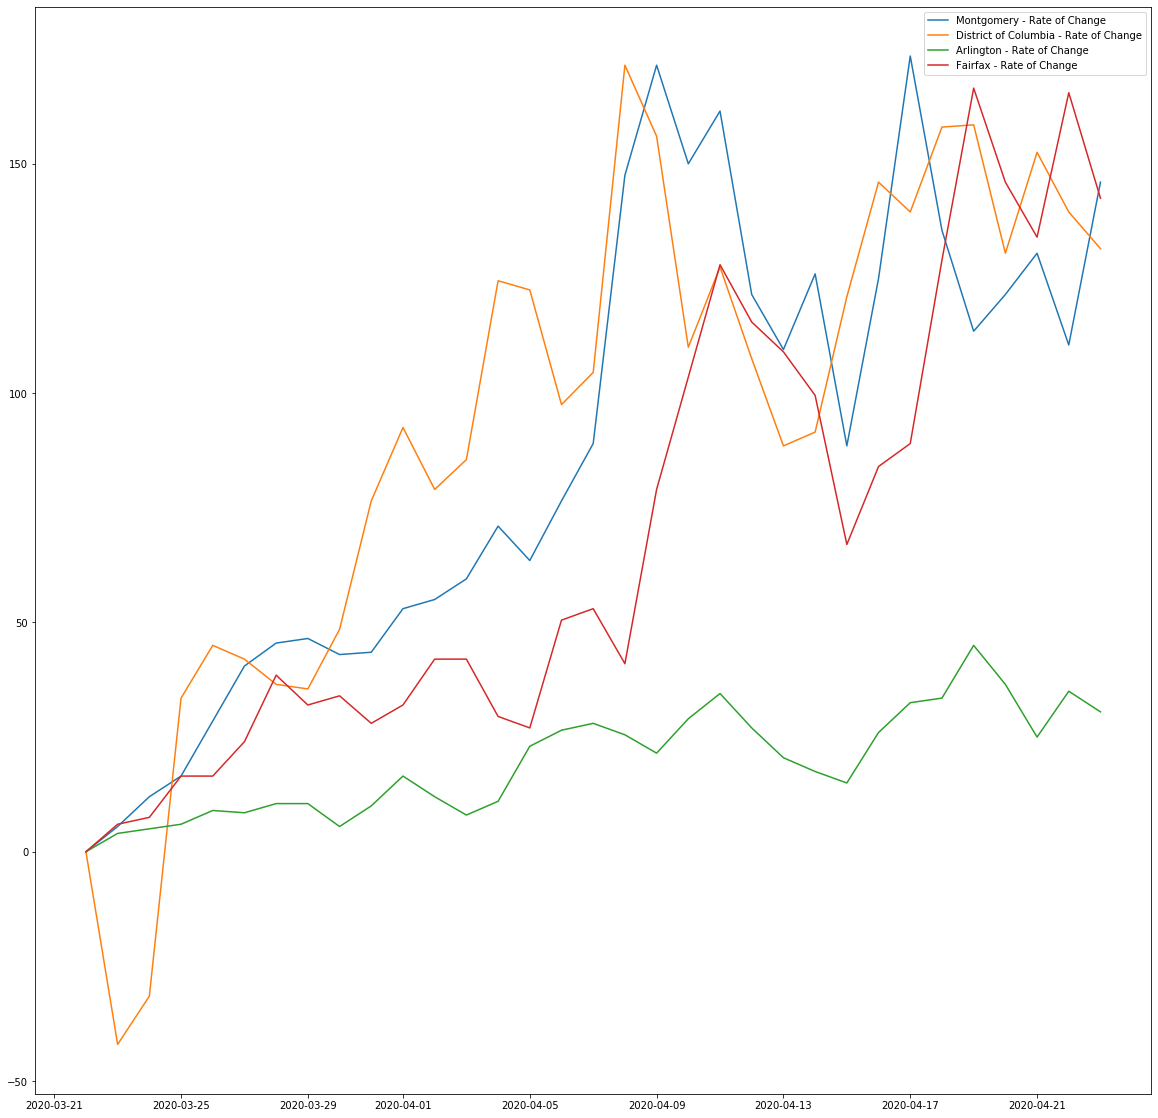

In [36]:
%local
plt.figure(figsize=(20,20))
for index in df_dmv_counties.index:
  plt.plot('date', 'RateOfChange', data=df_dmv_rateChange.loc[df_dmv_rateChange['county']==df_dmv_counties['county'][index]],label=df_dmv_counties['county'][index] + ' - Rate of Change')
  plt.text
plt.legend()
plt.show()

In [41]:
df_nyc = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
admin2 as county, sum(confirmed) as numConfirmed, sum(deaths) as numDeaths 
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'New York' ) and ( admin2 = 'New York City' ) 
group by admin2, unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_nyc.show()

my_window = Window.partitionBy().orderBy("date")

df_nyc = df_nyc.withColumn("dayBefore", F.lag(df_nyc.numConfirmed).over(my_window))
df_nyc = df_nyc.withColumn("change", F.when(F.isnull(df_nyc.numConfirmed - df_nyc.dayBefore), 0).otherwise(df_nyc.numConfirmed - df_nyc.dayBefore))

df_nyc = df_nyc.withColumn("dayBeforeDeaths", F.lag(df_nyc.numDeaths).over(my_window))
df_nyc = df_nyc.withColumn("changeDeaths", F.when(F.isnull(df_nyc.numDeaths - df_nyc.dayBeforeDeaths), 0).otherwise(df_nyc.numDeaths - df_nyc.dayBeforeDeaths))


df_nyc.show(df_nyc.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------+------------+---------+
|               date|       county|numConfirmed|numDeaths|
+-------------------+-------------+------------+---------+
|2020-03-22 00:00:00|New York City|        9654|       63|
|2020-03-23 00:00:00|New York City|       12305|       99|
|2020-03-24 00:00:00|New York City|       14904|      131|
|2020-03-25 00:00:00|New York City|       17856|      199|
|2020-03-26 00:00:00|New York City|       21873|      281|
|2020-03-27 00:00:00|New York City|       25573|      366|
|2020-03-28 00:00:00|New York City|       29776|      517|
|2020-03-29 00:00:00|New York City|       33768|      678|
|2020-03-30 00:00:00|New York City|       37453|      790|
|2020-03-31 00:00:00|New York City|       43119|      932|
|2020-04-01 00:00:00|New York City|       47439|     1139|
|2020-04-02 00:00:00|New York City|       51809|     1397|
|2020-04-03 00:00:00|New York City|       57159|     1584|
|2020-04-04 00:00:00|New York City|       63306|     190

In [42]:
%spark -o df_nyc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

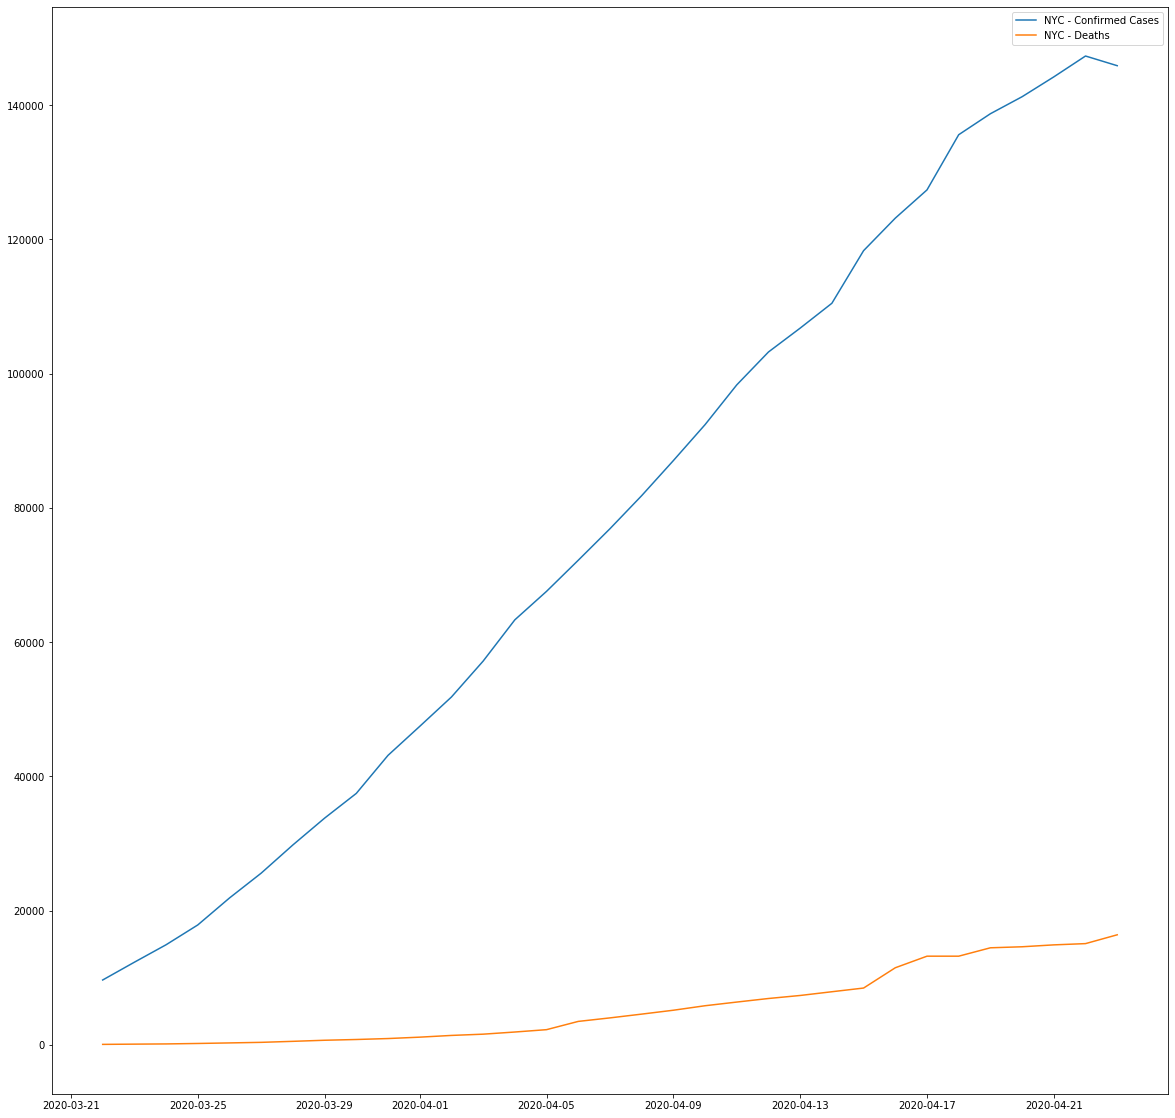

In [43]:
%local
plt.figure(figsize=(20,20))
plt.plot('date', 'numConfirmed', data=df_nyc, label="NYC - Confirmed Cases")
plt.plot('date', 'numDeaths', data=df_nyc, label="NYC - Deaths")
plt.text
plt.legend()
plt.show()

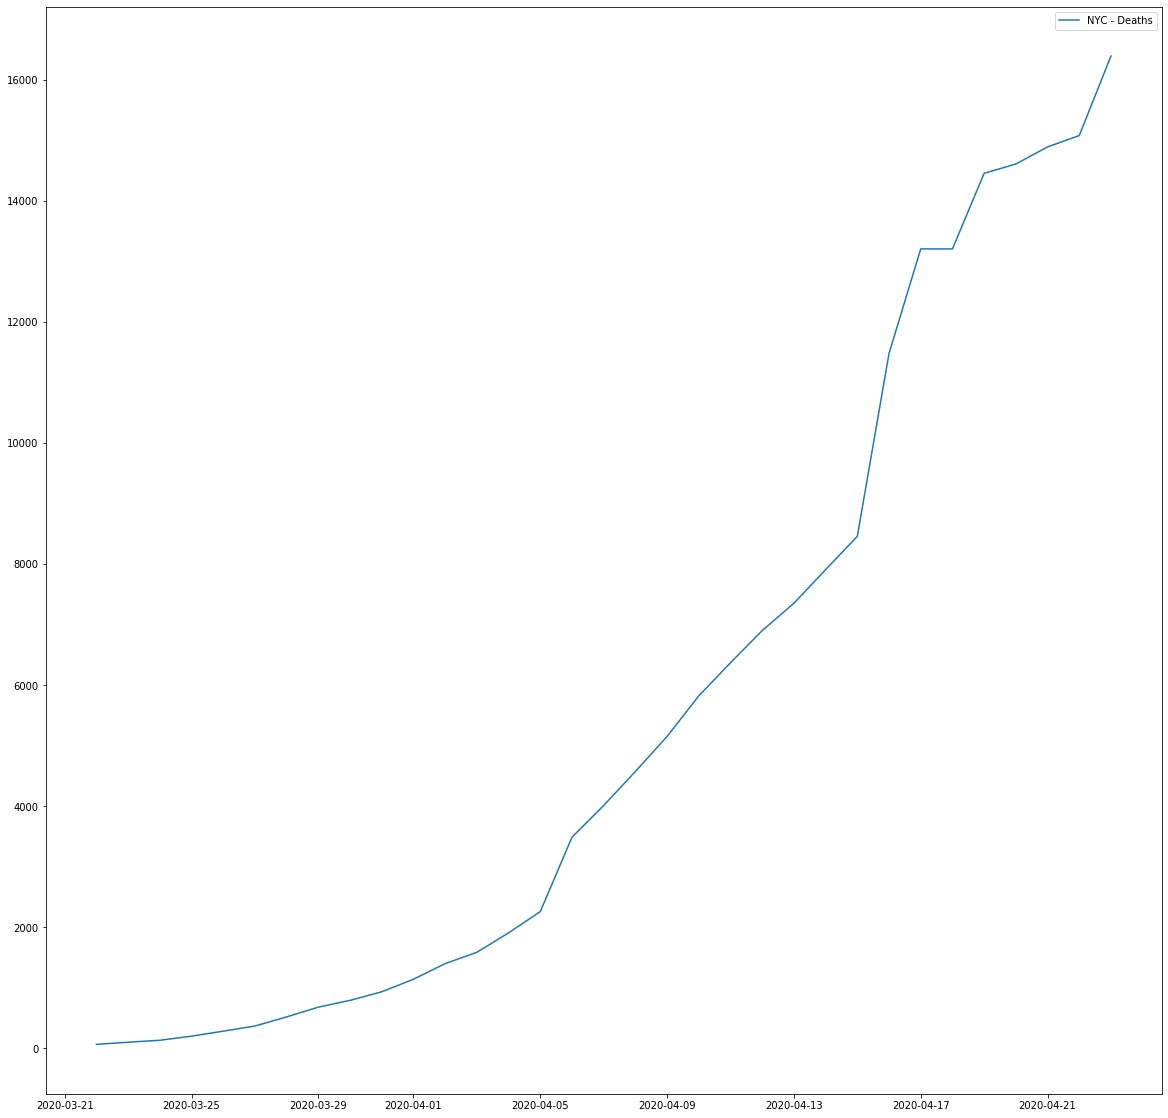

In [44]:
%local
plt.figure(figsize=(20,20))
plt.plot('date', 'numDeaths', data=df_nyc, label="NYC - Deaths")
plt.text
plt.legend()
plt.show()